In [66]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import pandas as pd

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [67]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'INTC'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [68]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

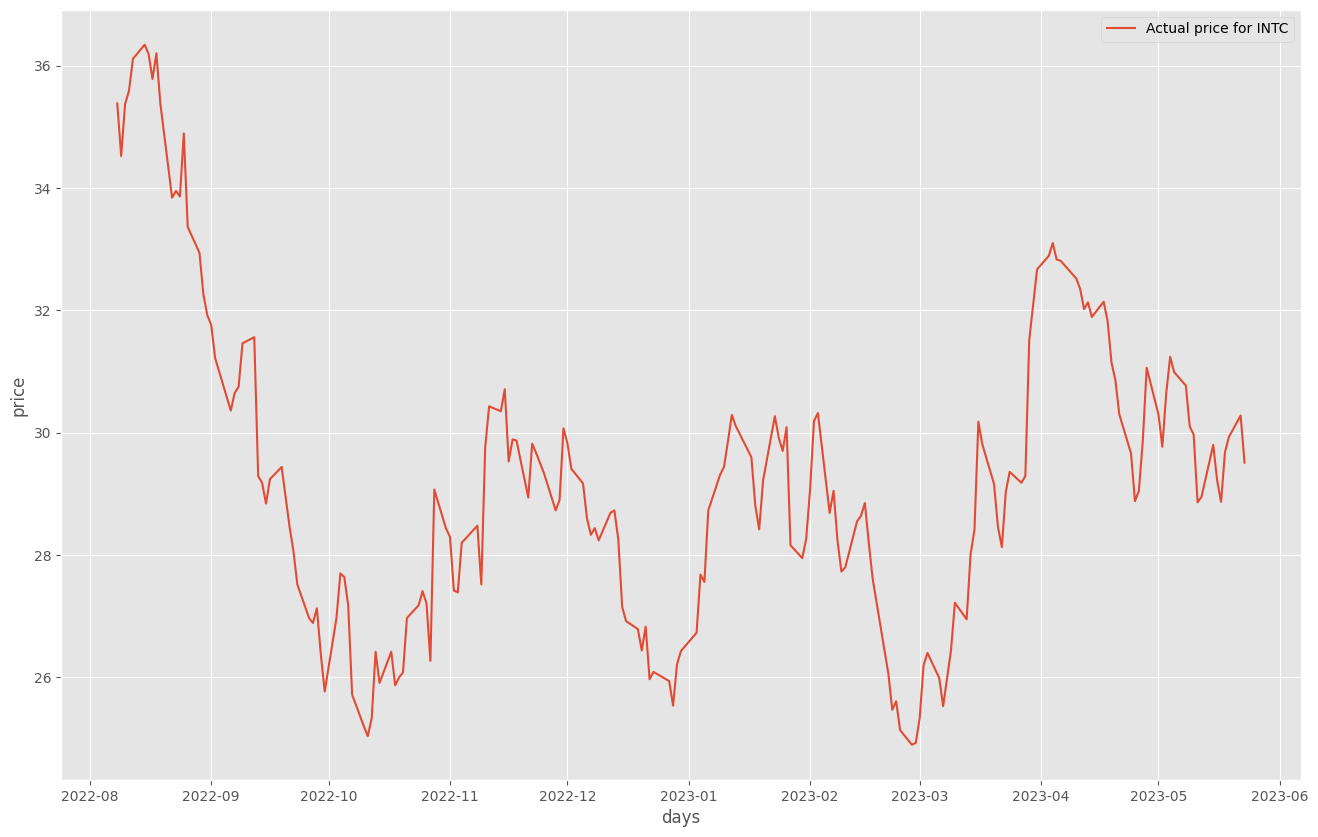

In [69]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [70]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close_scaled'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))
init_df

,close,date,close_scaled
2020-05-15,58.279999,2020-05-15,0.769834
2020-05-18,59.919998,2020-05-18,0.807657
2020-05-19,60.290001,2020-05-19,0.816190
2020-05-20,63.099998,2020-05-20,0.880996
2020-05-21,61.980000,2020-05-21,0.855166
...,...,...,...
2023-05-17,28.870001,2023-05-17,0.091559
2023-05-18,29.680000,2023-05-18,0.110240
2023-05-19,29.930000,2023-05-19,0.116006
2023-05-22,30.280001,2023-05-22,0.124078


In [71]:
def prepare_data(days):
    df = init_df.copy()
    df['future'] = df['close_scaled'].shift(-days)
    last_sequence = np.array(df[['close_scaled']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    for entry, target in zip(df[['close_scaled'] + ['date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(['close_scaled'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return df, last_sequence, X, Y

In [72]:
def get_trained_model(x_train, y_train):
    model = Sequential()
    model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close_scaled']))))
    model.add(Dropout(0.3))
    model.add(LSTM(120, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Dense(1))

    BATCH_SIZE = 8
    EPOCHS = 120

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=1)

    model.summary()

    return model

In [73]:
# GET PREDICTIONS
predictions = []

In [74]:
for step in LOOKUP_STEPS:
    df, last_sequence, x_train, y_train = prepare_data(step)
    x_train = x_train[:, :, :len(['close_scaled'])].astype(np.float32)

    model = get_trained_model(x_train, y_train)

    last_sequence = last_sequence[-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    predictions.append(round(float(predicted_price), 2))

Epoch 1/120
95/95 [==============================] - 4s 11ms/step - loss: 0.0217
Epoch 2/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0050
Epoch 3/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0054
Epoch 4/120
95/95 [==============================] - 1s 12ms/step - loss: 0.0034
Epoch 5/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0039
Epoch 6/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0038
Epoch 7/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0036
Epoch 8/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 9/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0026
Epoch 10/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0031
Epoch 11/120
95/95 [==============================] - 1s 12ms/step - loss: 0.0029
Epoch 12/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0028
Epoch 13/120
95/95 [=====

95/95 [==============================] - 1s 11ms/step - loss: 0.0016
Epoch 102/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 103/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0015
Epoch 104/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 105/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0013
Epoch 106/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0015
Epoch 107/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 108/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0013
Epoch 109/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0015
Epoch 110/120
95/95 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 111/120
95/95 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 112/120
95/95 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 113/120
95/9

Epoch 66/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 67/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 68/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 69/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 70/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 71/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 72/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 73/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 74/120
95/95 [==============================] - 1s 10ms/step - loss: 0.0023
Epoch 75/120
95/95 [==============================] - 1s 10ms/step - loss: 0.0021
Epoch 76/120
95/95 [==============================] - 1s 10ms/step - loss: 0.0020
Epoch 77/120
95/95 [==============================] - 1s 10ms/step - loss: 0.0022
Epoch 78/120
95/95 [====

94/94 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 32/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0034
Epoch 33/120
94/94 [==============================] - 1s 9ms/step - loss: 0.0032
Epoch 34/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0031
Epoch 35/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0033
Epoch 36/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0027
Epoch 37/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0031
Epoch 38/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 39/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0031
Epoch 40/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0030
Epoch 41/120
94/94 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 42/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 43/120
94/94 [=====================

                                                                 
Total params: 104,201
Trainable params: 104,201
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 525ms/step


In [121]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed
copy_df.drop('close_scaled', axis=1, inplace=True)
derived_mean=copy_df[f'close'].mean()-copy_df[f'predicted_close'].mean()
derived_mean=round(derived_mean, 2)

24/24 [==============================] - 0s 8ms/step


In [122]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

In [123]:
copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0]

In [124]:
copy_df.tail(10)

,close,date,predicted_close
2023-05-15 00:00:00,29.799999,2023-05-15 00:00:00,28.218155
2023-05-16 00:00:00,29.219999,2023-05-16 00:00:00,28.005375
2023-05-17 00:00:00,28.870001,2023-05-17 00:00:00,27.745142
2023-05-18 00:00:00,29.680000,2023-05-18 00:00:00,28.059809
2023-05-19 00:00:00,29.930000,2023-05-19 00:00:00,29.930000
2023-05-22 00:00:00,30.280001,2023-05-22 00:00:00,30.280001
2023-05-23 00:00:00,29.510000,2023-05-23 00:00:00,29.510000
2023-05-24,29.600000,2023-05-24,0.000000
2023-05-25,29.650000,2023-05-25,0.000000
2023-05-26,28.370000,2023-05-26,0.000000


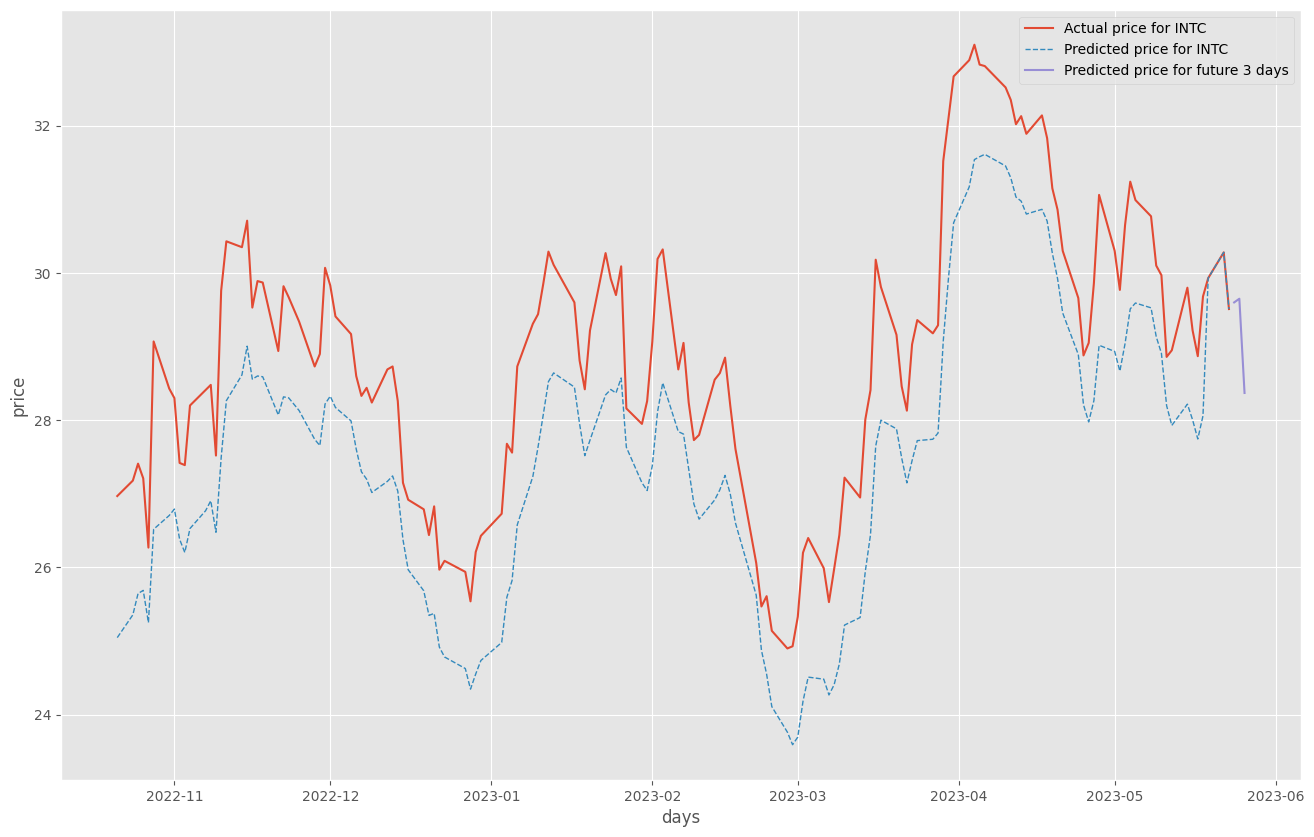

In [125]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(3))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

In [128]:
type(min(predictions_list))

str

In [131]:
if bool(predictions) == True and len(predictions) > 0:
    predictions_list = ['$'+str(d) for d in predictions]
    predictions_str = ', '.join(predictions_list)
    predictions_array = [d for d in predictions]
    buy = str(round(min(predictions_array), 2))
    sell = str(round(max(predictions_array)+derived_mean, 2))
    message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
    signal = f'BUY {STOCK} at ${buy}\nSELL {STOCK} at ${sell}'
    
    print(message)
    print(signal)

INTC prediction for upcoming 3 days ($29.6, $29.65, $28.37)
BUY INTC at $28.37
SELL INTC at $30.59
